In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv('/kaggle/input/an-online-shop-business/Sales Transaction v.4a.csv')
df.head()

In [ ]:
df.info()

In [ ]:

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Weekday'] = df['Date'].dt.strftime('%A')
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

In [ ]:
df.head()

In [ ]:
#尋找缺失值
df.isnull().sum()

In [ ]:
df[df['CustomerNo'].isnull()]

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

In [ ]:
df.info()

******************

How was the sales trend over the months?

What are the most frequently purchased products?

How many products does the customer purchase in each transaction?

What are the most profitable segment customers?

Based on your findings, what strategy could you recommend to the business to gain more profit?

In [ ]:
df['Total']=df['Quantity']* df['Price']


In [ ]:
df.head(-5)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
df_2019 = df.groupby('Year').get_group(2019)
trade = df_2019[df_2019['Total'] >= 0].groupby('Month')['Total'].sum()
cancel = df_2019[df_2019['Total'] <= 0].groupby('Month')['Total'].sum().abs()


In [ ]:
months = np.arange(1, 13)
fig = go.Figure()
fig.add_trace(go.Bar(x=months,
                     y=trade,
                     name='trade',
                     marker_color='blue',))

fig.add_trace(go.Bar(x=months,
                     y=cancel.abs(),
                     name='cancel',
                     marker_color='red',
))

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Total in Millions',
    title='Sales Analysis by Month in 2019',
    xaxis=dict(
        tickmode='array',
        tickvals=months,
        ticktext=[calendar.month_name[month] for month in months],
        tickangle=45
    ),
    barmode='group'
)


fig.show()

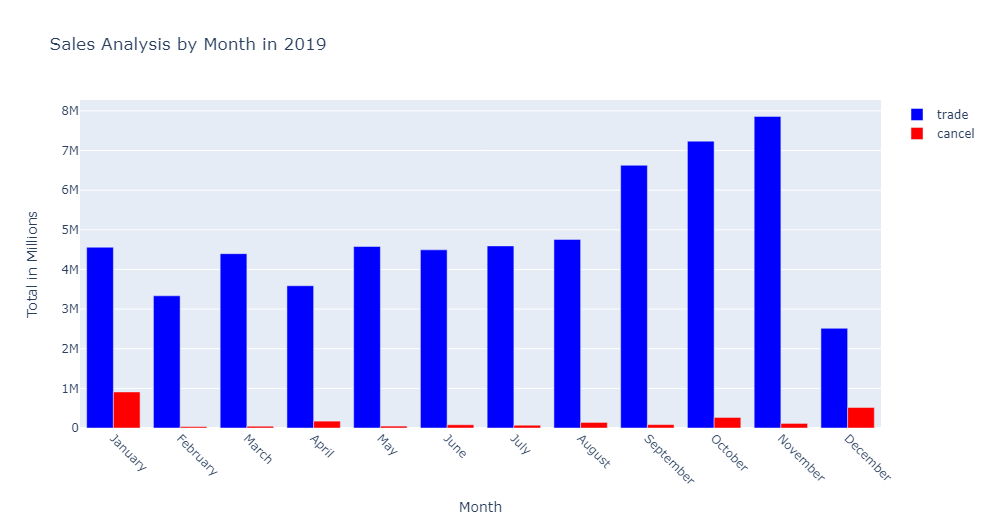

In [ ]:
sales_by_day = df_2019.groupby(['Month', 'Day'])['Total'].sum().reset_index()
sales_by_day.head()

In [ ]:
fig = px.line(sales_by_day, x="Day", y="Total", markers=True, symbol="Month",color="Month")
fig.update_layout(title_text='Month of Sale')              
fig.show()

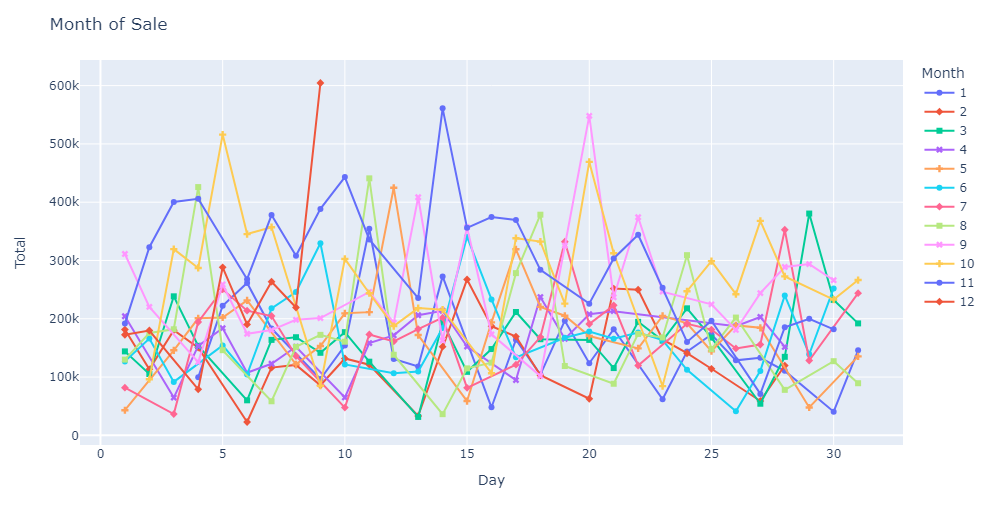

In [ ]:
fig = px.scatter(df_2019, x='Price', y='Quantity', title='Price vs Quantity',
                 labels={'Price': 'Price', 'Quantity': 'Quantity'}, render_mode='webgl')
fig.update_layout(xaxis_range=[0, 40], yaxis_range=[0, 500])
fig.show()

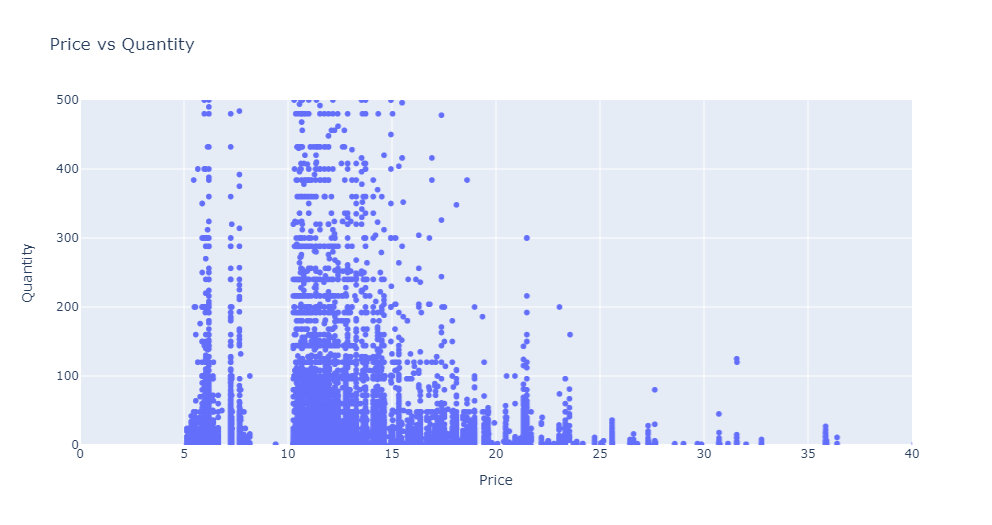

# Products

In [ ]:
Product_sale = df_2019.groupby('ProductName')['Total'].sum().reset_index().sort_values(by='Total', ascending=False).head(10)
fig = px.bar(Product_sale, x='ProductName', y='Total', color='ProductName', title='Top 10 Selling Products')
fig.show()

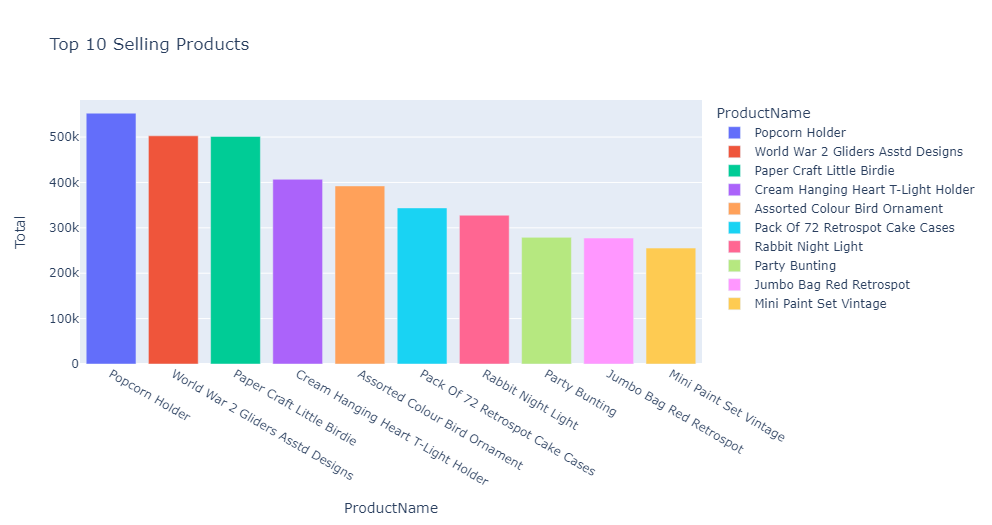

In [ ]:
PSQ = []
for j in Product_sale.loc[:,'ProductName']:
    PSQ.append(df_2019[df_2019['ProductName']==j]['Quantity'].sum())
#PSQ
Product_sale['Quantity']=PSQ
Product_sale

In [ ]:
top_10_PQ=df_2019.groupby('ProductName')['Quantity'].sum().reset_index().sort_values('Quantity',ascending=False).head(10)
PQS=[]
for i in top_10_PQ.loc[:,'ProductName']:
    PQS.append(df_2019[df_2019['ProductName']==i]['Total'].sum())

top_10_PQ['Total'] = PQS
#PQ
fig = px.bar(top_10_PQ, x='ProductName', y='Total', color='ProductName', title='Top 10 Quantity')
fig.show()

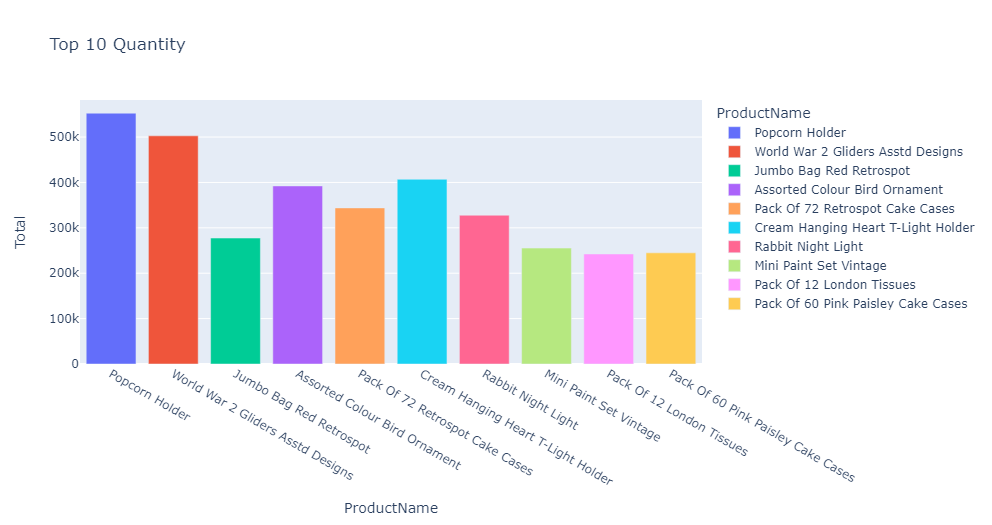

In [ ]:
top_10_PQ

# Country

In [ ]:
country_sales = df_2019.groupby('Country')['Total'].sum()
labels = country_sales.index
values = country_sales.values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='none')])
fig.update_layout(title='Total Sales by Country')
fig.show()

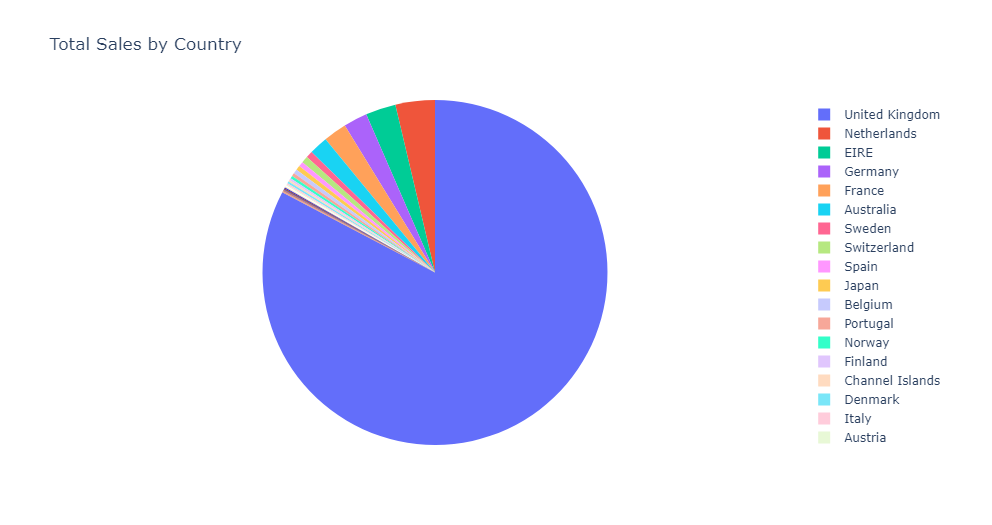

In [ ]:
country_product = df_2019[df_2019['Country']=='United Kingdom']
top_10_uk = country_product.groupby('ProductName',as_index = False)['Total'].count().sort_values('Total', ascending = False).head(10)
fig = px.bar(top_10_uk, x='ProductName', y='Total', color='ProductName', title='Top 10 Products Number of transactions in UK')
fig.show()

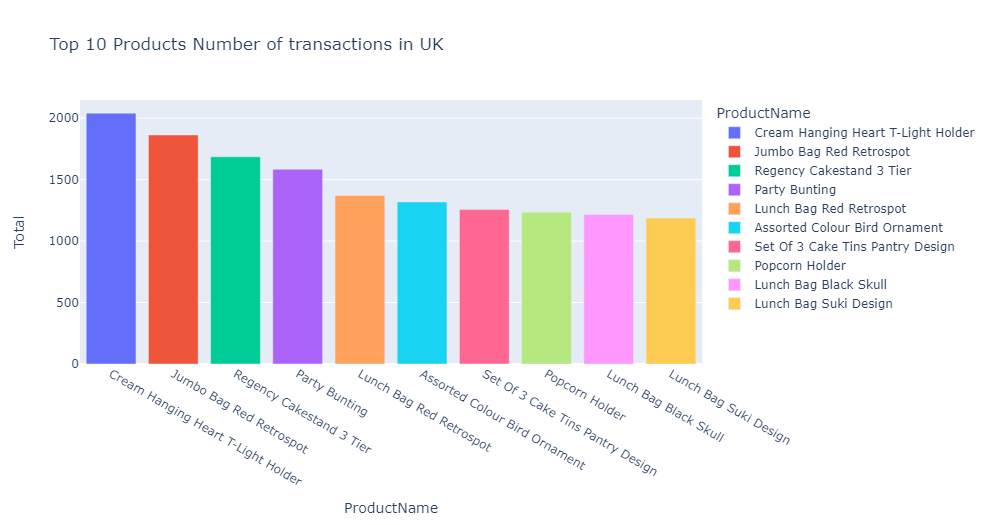

In [ ]:
top_10_income = country_product.groupby('ProductName',as_index = False)['Total'].sum().sort_values('Total', ascending = False).head(10)
fig = px.bar(top_10_income, x='ProductName', y='Total', color='ProductName', title='Top 10 Products Selling in UK')
fig.show()

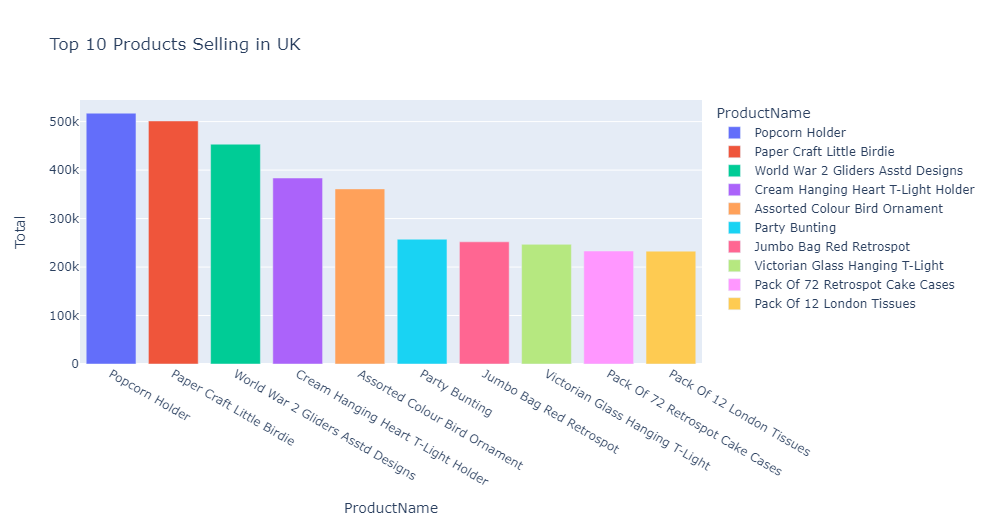

In [ ]:
df_2019[df_2019['TransactionNo']=='576365'].loc[:,['ProductName','Quantity']]

# Cancel

In [ ]:
cancel_2019 = df_2019[df_2019['Quantity']<=0]
cancel_product = cancel_2019.groupby('ProductName')['Quantity'].sum().reset_index().sort_values(by='Quantity',ascending=True).head()
fig = px.bar(cancel_product, x='ProductName', y='Quantity', color='ProductName', title='Top cancel Products')
fig.show()

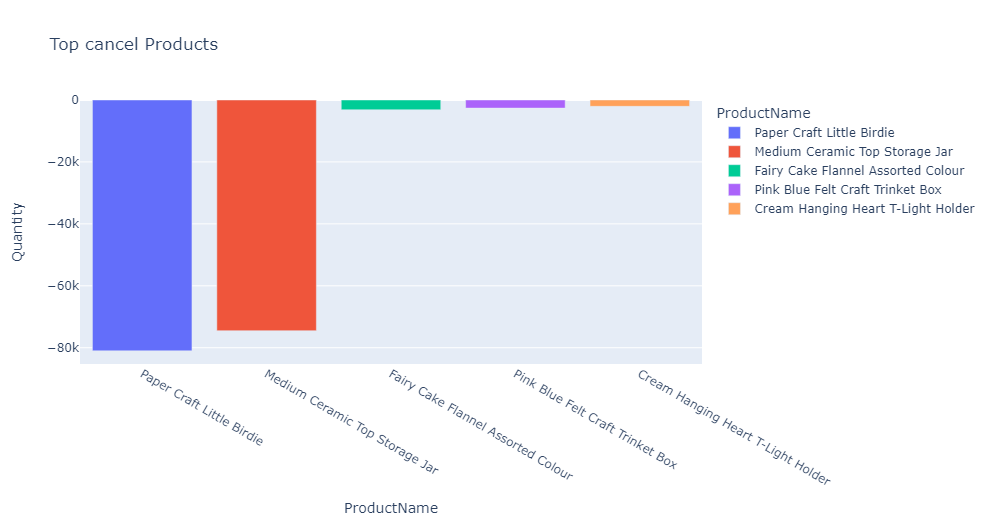****

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

transactions = df_2019.groupby('TransactionNo').apply(lambda x: list(x['ProductName']))
transactions_Total = df_2019.groupby('TransactionNo').apply(lambda x: x['Total'].sum())
c = {
    'ProductName' : transactions.values,
    'Total' : transactions_Total
}
transactions_df = pd.DataFrame(c).sort_values(by='Total',ascending=False)['ProductName'].head(5000).to_list()
#transactions_df.sort_values(by='Total',ascending=False)['ProductName'].head(5000).to_list()

encoder = TransactionEncoder().fit(transactions_df)
onehot = encoder.transform(transactions_df)
onehot = pd.DataFrame(onehot, columns=encoder.columns_)

# Selecting frequent itemsets with apriori algorythm
frequent_itemsets = apriori(onehot,
                            min_support = 0.05, 
                            max_len = 5, 
                            use_colnames = True)
print('Number of itemsets selected by the Apriori algorithm:', len(frequent_itemsets))

In [ ]:
frequent_itemsets

In [ ]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.7)

# Adding number of items in the itemsets
rules['n_antecedents'] = rules['antecedents'].apply(lambda x: len(x))
rules['n_consequents'] = rules['consequents'].apply(lambda x: len(x))
rules